In [1]:
import os
import sys
import time
import configparser
%matplotlib inline
%load_ext autoreload
%autoreload 2

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

config = configparser.ConfigParser()
config.read('config_jj.ini')

#TO BE CONFIGURED FROM CONFIG FILE
os.environ['ICTDIR'] = config['Paths']['ICTDIR']
os.environ["PATH"] = os.environ["PATH"] + config['Paths']['PATH_APPEND']
# Define the folder base path these are to run in local
base_path = config['Paths']['BASE_PATH']
path_to_wf = config['Paths']['PATH_TO_WF']
path_to_dst = config['Paths']['PATH_TO_DST']
print(os.environ["PATH"])

/Users/jjgomezcadenas/NEXT/IC-v2-on-master/bin:/Users/jjgomezcadenas/miniconda3/envs/IC-3.8-2024-06-08/bin:/Users/jjgomezcadenas/Software/geant4-11.2.2-build/bin:/Users/jjgomezcadenas/miniconda3/condabin:/Users/jjgomezcadenas/.juliaup/bin:/Users/jjgomezcadenas/.nix-profile/bin:/nix/var/nix/profiles/default/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/Library/Apple/usr/bin:/Library/TeX/texbin:/Users/jjgomezcadenas/.local/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/Users/jjgomezcadenas/.local/bin:/Users/jjgomezcadenas/NEXT/IC/bin


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from dataclasses import dataclass

In [3]:
import histograms as hst

In [4]:
import invisible_cities.core.fit_functions as ifit

In [5]:
import analysis_functions as ia

In [61]:
from typing import List, Optional

## Functions

In [6]:
def merge_hdfs(folderdata):
    dfs = []
    for root, _, files in os.walk(folderdata):
        for f in files:
            if f.endswith(('.h5', '.hdf5')):
                dfs.append(pd.read_hdf(os.path.join(root, f), '/DST/Events'))
    return pd.concat(dfs, ignore_index=True)

## Analysis

### Read data

In [7]:
run_number = 15504
ldc="/ldc1"
dstpath =f"{base_path}{run_number}{path_to_dst}"
print(f"path to dst files = {dstpath}")

path to dst files = /Users/jjgomezcadenas/NEXT/analysis/15504/hdf5/prod/v2.3.1/20250512/sophronia/trigger1


In [8]:
for dirpath, dirnames, filenames in os.walk(dstpath):
    print(dirpath, dirnames,  len(filenames))

/Users/jjgomezcadenas/NEXT/analysis/15504/hdf5/prod/v2.3.1/20250512/sophronia/trigger1 ['ldc6', 'ldc1', 'ldc7', 'ldc2', 'ldc5', 'ldc4', 'ldc3'] 0
/Users/jjgomezcadenas/NEXT/analysis/15504/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc6 [] 2331
/Users/jjgomezcadenas/NEXT/analysis/15504/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc1 [] 2336
/Users/jjgomezcadenas/NEXT/analysis/15504/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc7 [] 2335
/Users/jjgomezcadenas/NEXT/analysis/15504/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc2 [] 2332
/Users/jjgomezcadenas/NEXT/analysis/15504/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc5 [] 2332
/Users/jjgomezcadenas/NEXT/analysis/15504/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc4 [] 2334
/Users/jjgomezcadenas/NEXT/analysis/15504/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc3 [] 2326


In [9]:
df = merge_hdfs(dstpath)

In [10]:
df.head()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,733613,1.749156e+09,0,0,2,1,250.0,0.632469,2.798292,207525.0,...,16,1193.948975,1193.948975,3.452777,327.621877,-71.572782,335.348711,-0.215082,13.262095,13.591106
1,733613,1.749156e+09,1,0,2,1,125.0,1.180352,4.132585,1070000.0,...,16,331.473877,331.473877,3.452777,327.621877,-71.572782,335.348711,-0.215082,13.262095,13.591106
2,733620,1.749156e+09,0,0,2,1,400.0,0.842689,8.460991,615050.0,...,16,785.437134,785.437134,5.083665,350.791319,83.669932,360.631678,0.234143,13.881283,15.179773
3,733620,1.749156e+09,1,0,2,1,225.0,0.747229,2.881283,1121000.0,...,16,279.487152,279.487152,5.083665,350.791319,83.669932,360.631678,0.234143,13.881283,15.179773
4,733627,1.749156e+09,0,0,1,2,125.0,1.898561,6.680109,1165900.0,...,19,240.582642,240.582642,3.259296,56.219432,-46.947943,73.244343,-0.695771,13.552366,13.858096


In [11]:
df.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [12]:
ldf = len(np.unique(df['event']))
print(f"NEvent full dataset : {ldf}")

NEvent full dataset : 2745840


#### Number of S1 and S2

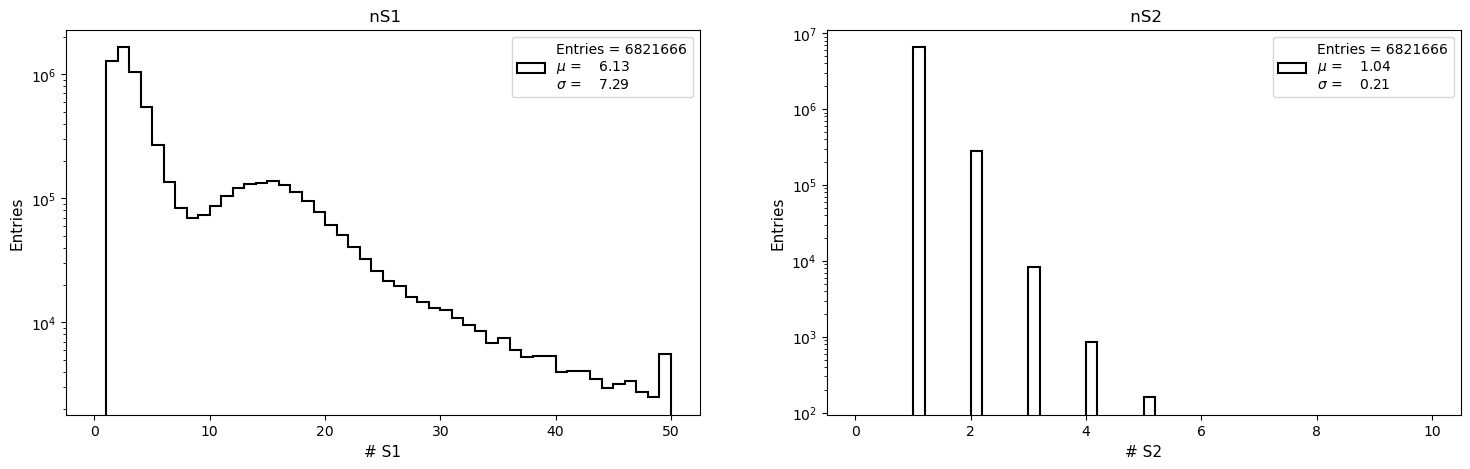

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
_ = hst.h1d(df.nS1, 50, [0,50], 
            ax = ax[0])
hst.plot_histo(hst.PlotLabels(x='# S1', y='Entries', title=" nS1"), ax[0], log=True)
           
_ = hst.h1d(df.nS2, 50, [0,10], 
            ax = ax[1])
hst.plot_histo(hst.PlotLabels(x='# S2', y='Entries', title=" nS2"), ax[1], log=True)
           
plt.show()

### Impose nS1 =1, nS2=1

In [14]:
dfs1= df[(df['nS1']==1) & (df['nS2']==1)]

In [15]:
ldfs1 = len(np.unique(dfs1['event']))
print(f"NEvent S1 = 1 & S2=1 : {len(np.unique(dfs1['event']))}")
print(f"eff:{(ldfs1/ldf)*100:.2f}%")

NEvent S1 = 1 & S2=1 : 1259715
eff:45.88%


### DT vs Zrms

In [16]:
h2zdt, xedges, yedges = np.histogram2d(dfs1.DT, dfs1.Zrms**2, bins=(100, 1000), range=[[0.0, 1350.0], [0, 50.0]], 
                                    weights=np.ones(len(dfs1.DT)))

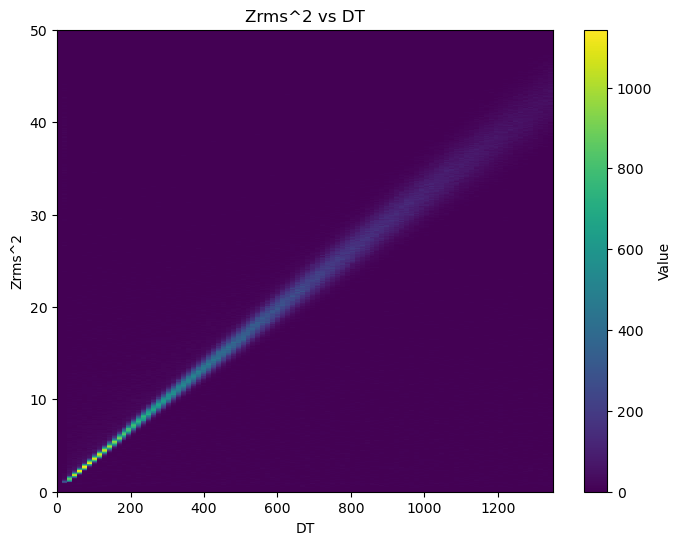

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
hst.plot_h2d(fig, ax, h2zdt, xedges, yedges, xlabel="DT", ylabel="Zrms^2", title="Zrms^2 vs DT")

### Select events contained in DT-Zrms² road

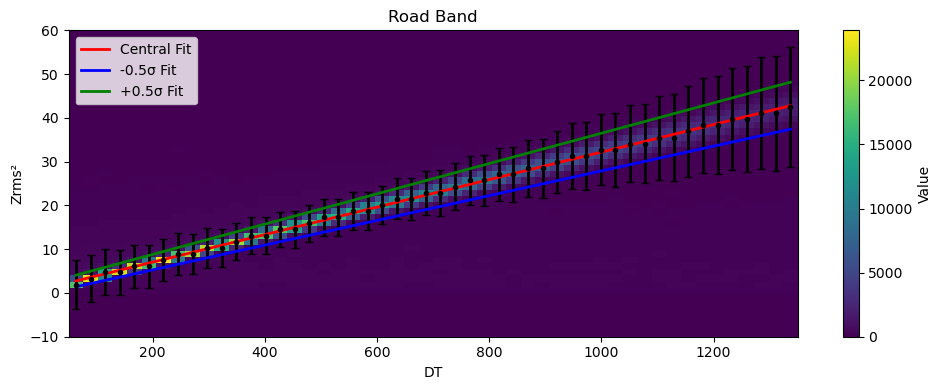

In [18]:
ff_c, ff_l, ff_u, dfrs1 = ia.road_dt_zrms2(
    dfs1, nbins=50, xrange=[50.0, 1350.0], yrange=[-10.0, 60.0],
    figsize=(10, 4), nsigma=0.5,
    xlabel="DT", ylabel="Zrms²", title="Road Band"
)

In [19]:
ldfrs1 = len(np.unique(dfrs1['event']))
print(f"NEvent filtered road : {len(np.unique(dfrs1['event']))}")
print(f"eff:{(ldfrs1/ldf)*100:.2f}%")

NEvent filtered road : 1064454
eff:38.77%


#### Correlation between S2e and S1e

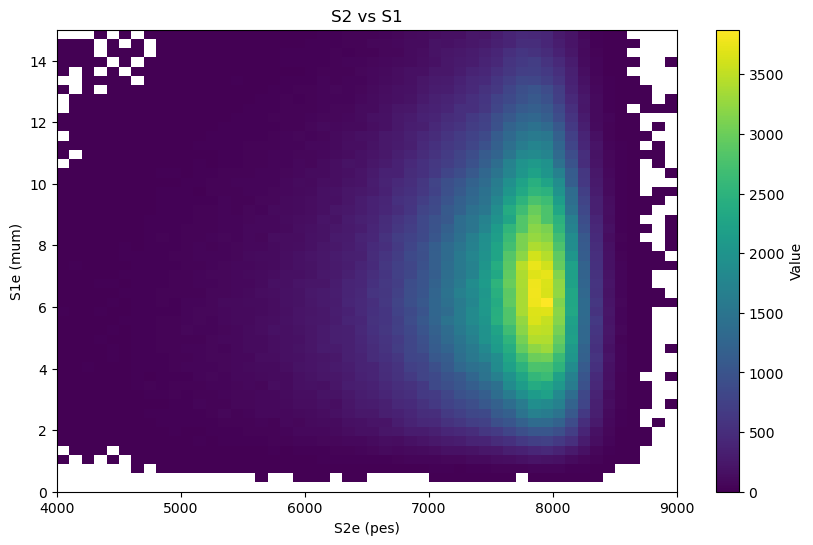

In [24]:
_ = hst.h2d(dfrs1.S2e, dfrs1.S1e, np.ones(len(dfrs1.S2e)), 50, 50, [4000.0, 9000.0], [0.0, 15.0], 
           pltLabels = hst.PlotLabels(x='S2e (pes)', y='S1e (mum)', title="S2 vs S1"))

#### S2e and DT

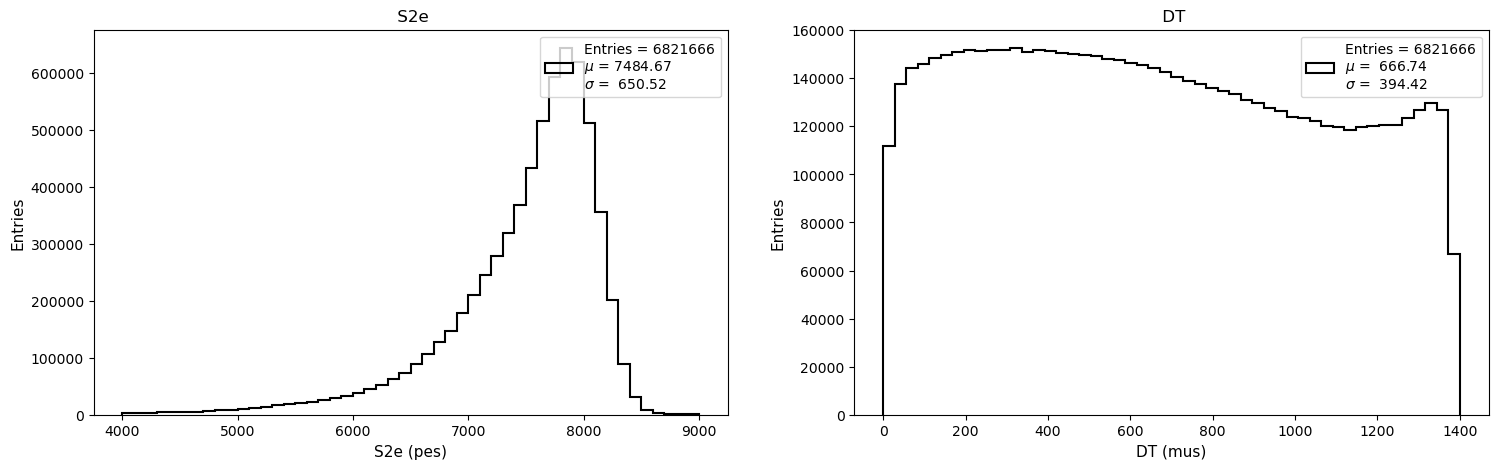

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
n, n, mu, std = hst.h1d(df.S2e, 50, [4000,9000], 
            ax = ax[0])
hst.plot_histo(hst.PlotLabels(x='S2e (pes)', y='Entries', title=" S2e"), ax[0], log=False)
           
_ = hst.h1d(df.DT, 50, [0,1400], 
            ax = ax[1])
hst.plot_histo(hst.PlotLabels(x='DT (mus)', y='Entries', title=" DT"), ax[1], log=False)
           
plt.show()

In [21]:
print(f"Raw S2e: sigma/mu = {2.3*std/mu}")

Raw S2e: sigma/mu = 0.19990143201949606


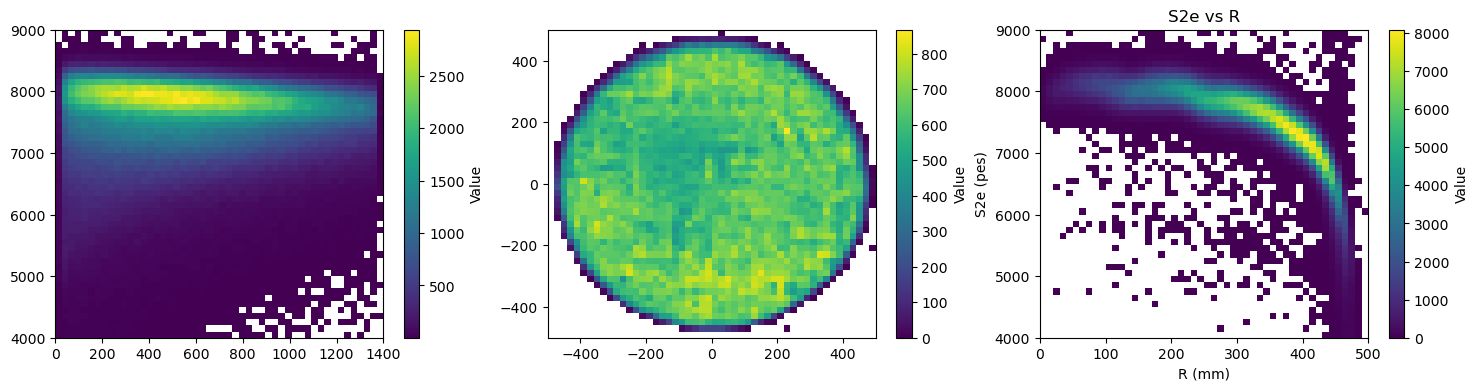

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
hlt, xelt, yelt = hst.h2d(dfrs1.DT, dfrs1.S2e, np.ones(len(dfrs1.S2e)), 50, 50, [0.0, 1400.0],[4000.0, 9000.0], vmin=1, 
           ax=ax[0], pltLabels = hst.PlotLabels(x='DT (mus)', y='S2e (pes)', title="S2 vs tz"))
_ = hst.h2d(dfrs1.X, dfrs1.Y, np.ones(len(dfrs1.X)),50, 50, [-500.0, 500.0], [-500.0, 500.0], 
           ax=ax[1], pltLabels = hst.PlotLabels(x='X (mm)', y='Y (mm)', title="X vs Y"))
_ = hst.h2d(dfrs1.R, dfrs1.S2e, np.ones(len(dfrs1.R)),50, 50, [0.0, 500.0], [4000.0, 9000.0], 
           ax=ax[2], pltLabels = hst.PlotLabels(x='R (mm)', y='S2e (pes)', title="S2e vs R"))
plt.show()

In [35]:
xlt, ymlt, yalt, ystdlt = ia.histogram_y_profile(hlt, xelt, yelt, errMean=False)

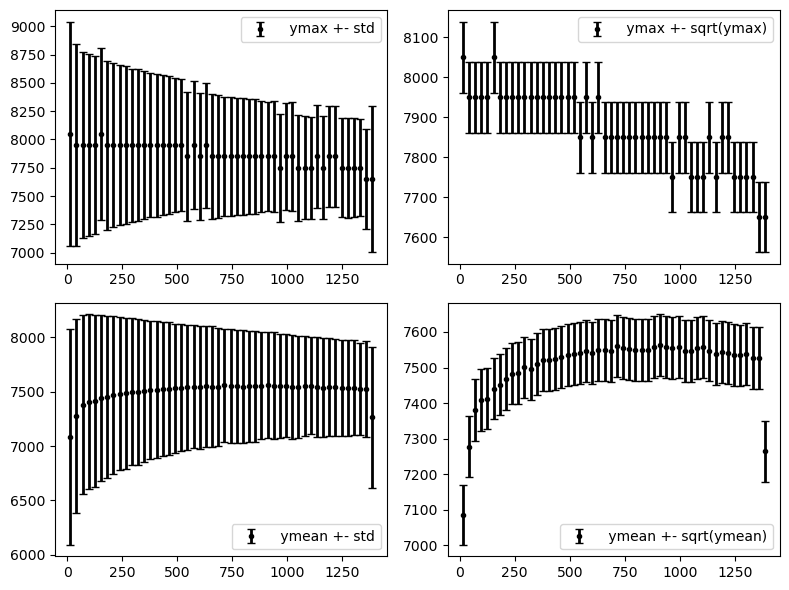

In [38]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
axs[0,0].errorbar(xlt, ymlt, yerr=ystdlt, fmt='o', ms=3, elinewidth=2, capsize=3, color='black', label=' ymax +- std')
axs[0,0].legend()
axs[0,1].errorbar(xlt, ymlt, yerr=np.sqrt(ymlt), fmt='o', ms=3, elinewidth=2, capsize=3, color='black', label=' ymax +- sqrt(ymax)')
axs[0,1].legend()
axs[1,0].errorbar(xlt, yalt, yerr=ystdlt, fmt='o', ms=3, elinewidth=2, capsize=3, color='black', label=' ymean +- std')
axs[1,0].legend()
axs[1,1].errorbar(xlt, yalt, yerr=np.sqrt(yalt), fmt='o', ms=3, elinewidth=2, capsize=3, color='black', label=' ymean +- sqrt(ymean)')
axs[1,1].legend()
fig.tight_layout()
plt.show()

#### NB: Distribution compatible with "infinite lifetime", 

#### Filter in S2e-R band

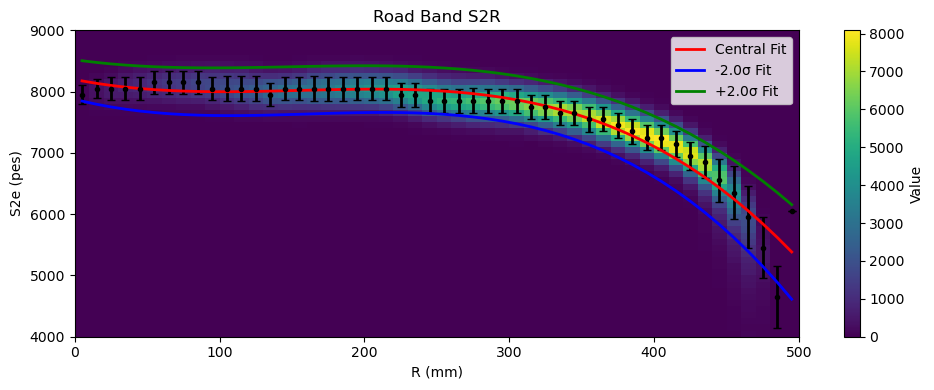

In [30]:
ff_c, ff_l, ff_u, dfrs2 = ia.road_r_s2e(
    dfrs1, nbins=50, xrange=[0.0, 500.0], yrange=[4000.0, 9000.0],
    figsize=(10, 4), nsigma=2.0,
    xlabel="R (mm)", ylabel="S2e (pes)", title="Road Band S2R"
)

In [31]:
ldfrs2 = len(np.unique(dfrs2['event']))
print(f"NEvent filtered road : {ldfrs2}")
print(f"eff:{(ldfrs2/ldf)*100:.2f}%")

NEvent filtered road : 1003110
eff:36.53%


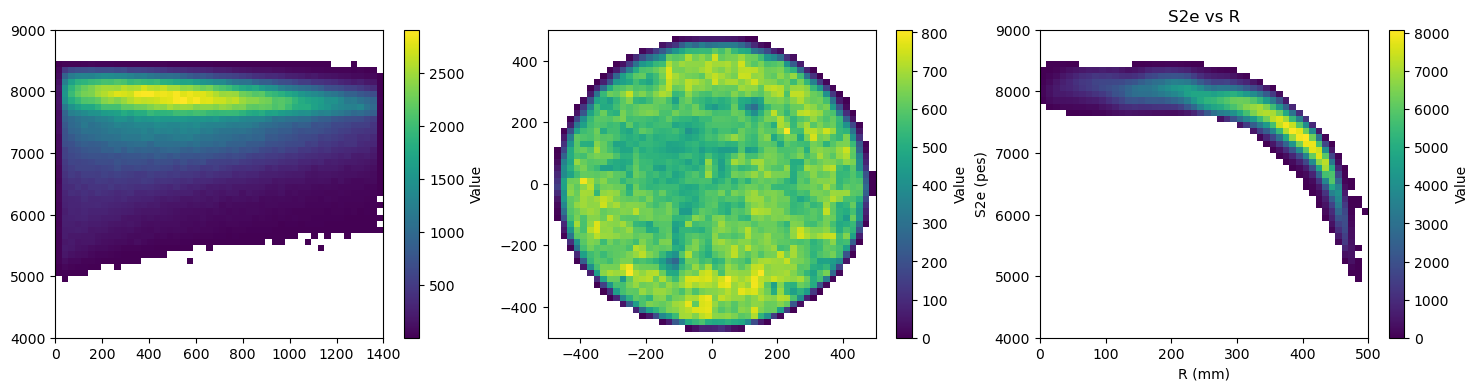

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
hlt, xelt, yelt = hst.h2d(dfrs2.DT, dfrs2.S2e, np.ones(len(dfrs2.S2e)), 50, 50, [0.0, 1400.0],[4000.0, 9000.0], vmin=1, 
           ax=ax[0], pltLabels = hst.PlotLabels(x='DT (mus)', y='S2e (pes)', title="S2 vs tz"))
_ = hst.h2d(dfrs2.X, dfrs2.Y, np.ones(len(dfrs2.X)),50, 50, [-500.0, 500.0], [-500.0, 500.0], 
           ax=ax[1], pltLabels = hst.PlotLabels(x='X (mm)', y='Y (mm)', title="X vs Y"))
_ = hst.h2d(dfrs2.R, dfrs2.S2e, np.ones(len(dfrs2.R)),50, 50, [0.0, 500.0], [4000.0, 9000.0], 
           ax=ax[2], pltLabels = hst.PlotLabels(x='R (mm)', y='S2e (pes)', title="S2e vs R"))
plt.show()

In [40]:
xlt, ymlt, yalt, ystdlt = ia.histogram_y_profile(hlt, xelt, yelt, errMean=False)

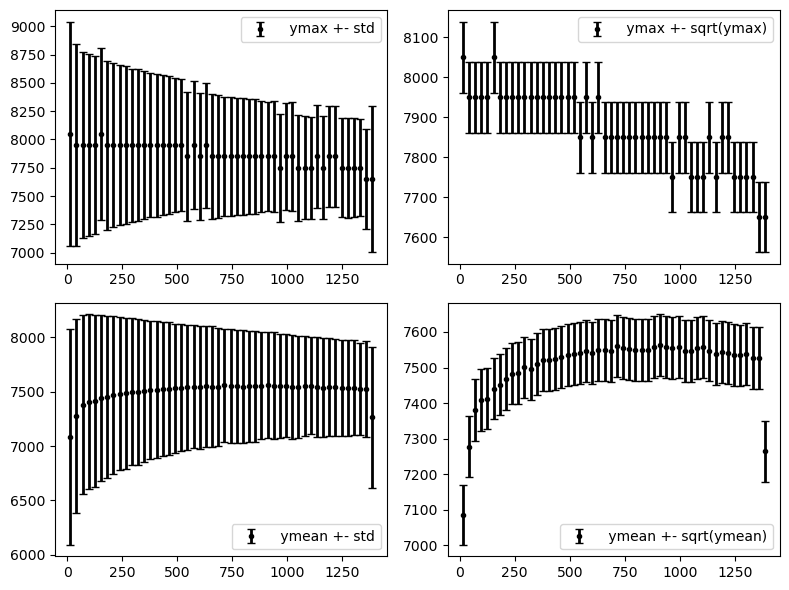

In [41]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
axs[0,0].errorbar(xlt, ymlt, yerr=ystdlt, fmt='o', ms=3, elinewidth=2, capsize=3, color='black', label=' ymax +- std')
axs[0,0].legend()
axs[0,1].errorbar(xlt, ymlt, yerr=np.sqrt(ymlt), fmt='o', ms=3, elinewidth=2, capsize=3, color='black', label=' ymax +- sqrt(ymax)')
axs[0,1].legend()
axs[1,0].errorbar(xlt, yalt, yerr=ystdlt, fmt='o', ms=3, elinewidth=2, capsize=3, color='black', label=' ymean +- std')
axs[1,0].legend()
axs[1,1].errorbar(xlt, yalt, yerr=np.sqrt(yalt), fmt='o', ms=3, elinewidth=2, capsize=3, color='black', label=' ymean +- sqrt(ymean)')
axs[1,1].legend()
fig.tight_layout()
plt.show()

#### S2e & DT

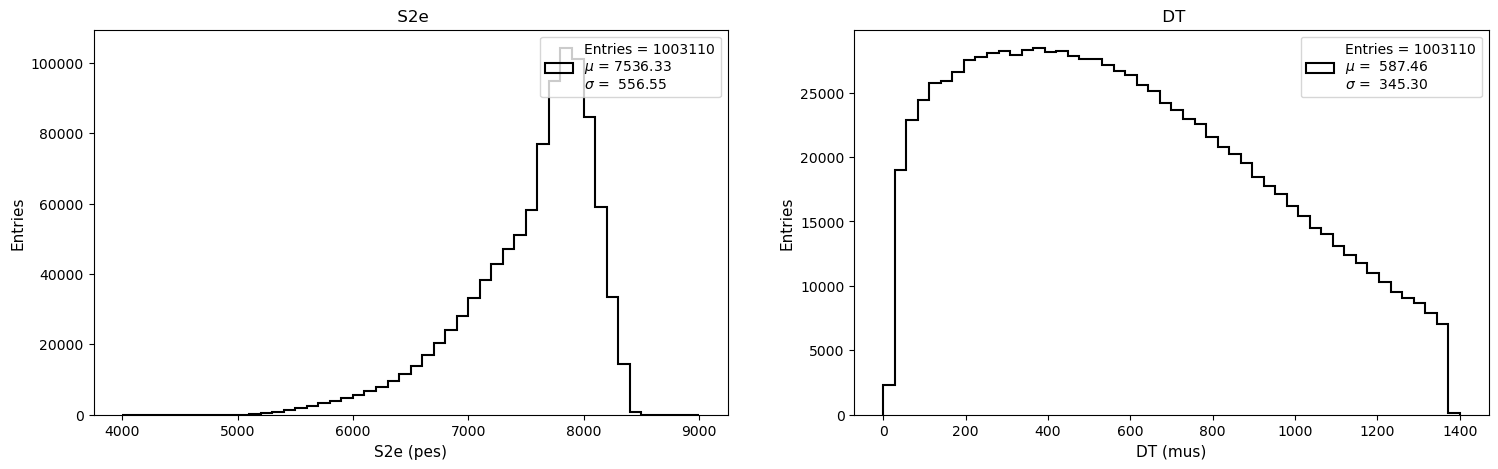

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
n, n, mu, std = hst.h1d(dfrs2.S2e, 50, [4000,9000], 
            ax = ax[0])
hst.plot_histo(hst.PlotLabels(x='S2e (pes)', y='Entries', title=" S2e"), ax[0], log=False)
           
_ = hst.h1d(dfrs2.DT, 50, [0,1400], 
            ax = ax[1])
hst.plot_histo(hst.PlotLabels(x='DT (mus)', y='Entries', title=" DT"), ax[1], log=False)
           
plt.show()

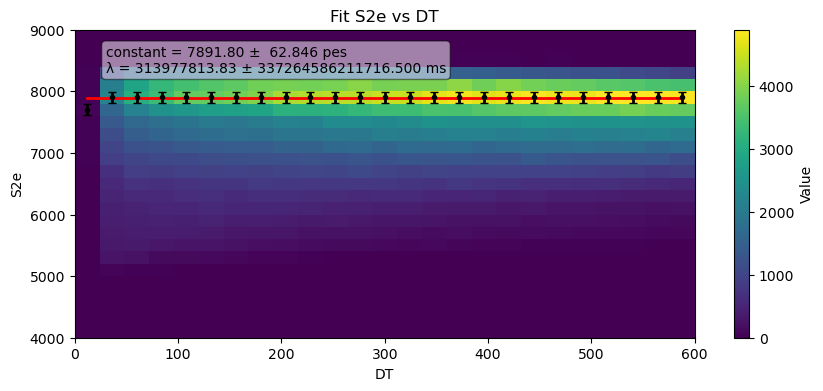

In [43]:
const, lamda = ia.fit_lifetime(dfrs2, nbins=25, dtrange=[0.0, 600.0], s2range=[4000, 9000])

### Maps

In [44]:
z_bins = np.array([0, 200, 400, 600, 800, 1350])
bins_xy = 100
krmap = ia.compute_map3D(dfrs2, bins_xy = bins_xy, z_bins=z_bins)

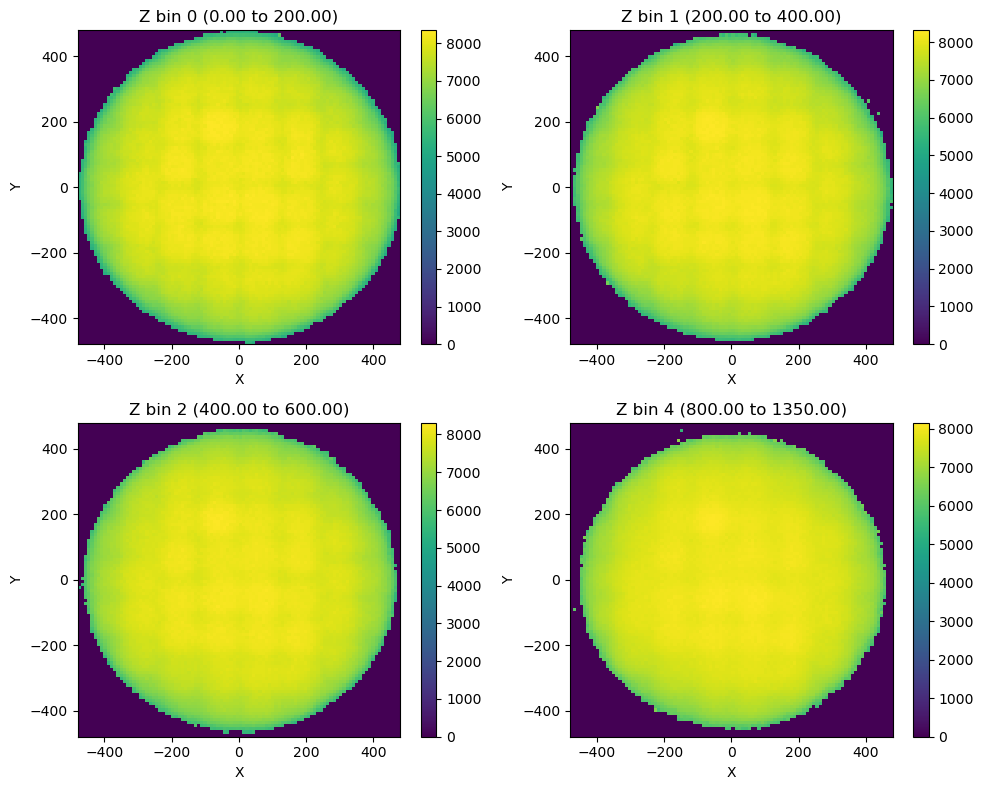

In [45]:
ia.plot_3d_histogram_slices(krmap.hratio, krmap.xedges, krmap.yedges, krmap.zedges, z_indices=[0, 1, 2, 4], figsize= (5, 4))

In [46]:
max_value = np.max(krmap.hratio)
max_index = np.unravel_index(np.argmax(krmap.hratio), krmap.hratio.shape)

print(f"max_value = {max_value},max_index={max_index}")



max_value = 8344.563598632812,max_index=(47, 47, 0)


In [47]:
hmap = np.divide(krmap.hratio, krmap.hratio[max_index], where=krmap.hcounts > 1)
krmap.hmap = hmap

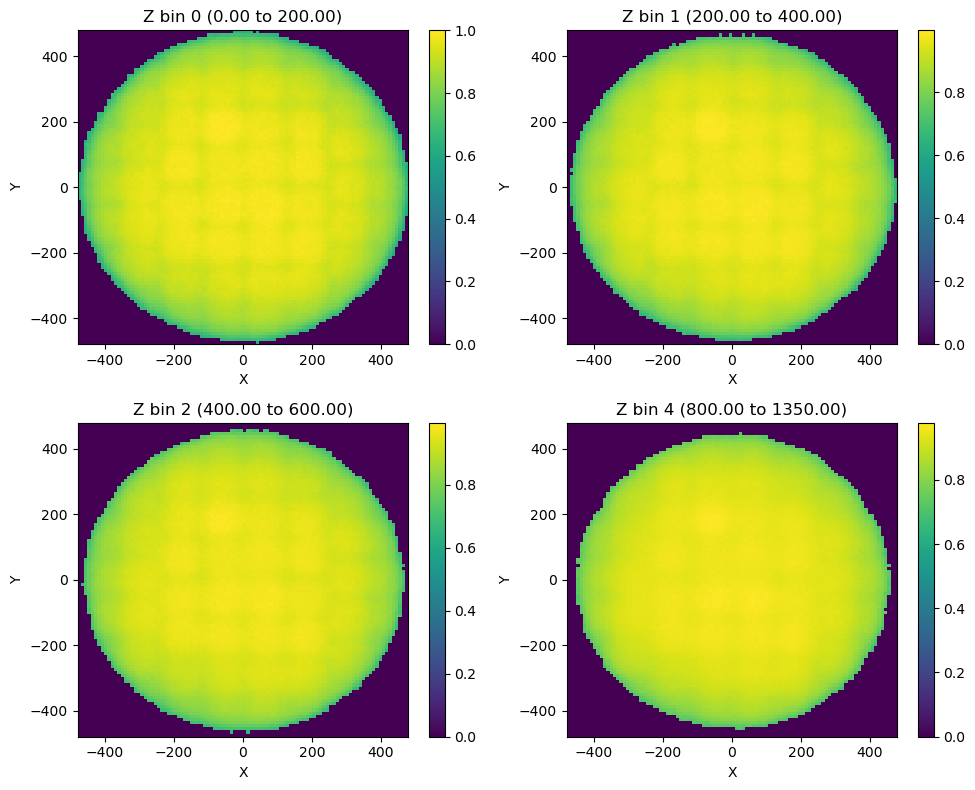

In [49]:
ia.plot_3d_histogram_slices(krmap.hmap, krmap.xedges, krmap.yedges, krmap.zedges, z_indices=[0, 1, 2, 4], figsize= (5, 4))

### Correct energy

In [56]:
dfc = ia.correct_S2e(dfrs2, krmap, rmax=480.0, zmax=1350.0)

In [57]:
dfc.head()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Z,Zrms,X,Y,R,Phi,Xrms,Yrms,Epes,corrections
18,733655,1.749156e+09,0,0,1,1,200.0,1.267977,7.618934,730025.0,...,674.468140,4.647549,-260.676486,-115.315227,285.043562,-2.725103,14.905645,13.455190,8376.187018,0.945750
23,733676,1.749156e+09,0,0,1,1,225.0,0.995394,5.108867,1280475.0,...,123.000381,2.060976,-19.087822,30.244837,35.764439,2.133777,13.724369,12.752165,8388.024880,0.975530
26,733690,1.749156e+09,0,0,1,1,200.0,2.554362,10.972893,1333275.0,...,70.201630,1.582437,379.319552,-169.885277,415.625228,-0.421080,12.665118,10.965740,8433.879251,0.851347
27,733704,1.749156e+09,0,0,1,1,275.0,1.412844,7.917659,498325.0,...,904.166687,5.334085,-195.512726,-107.712222,223.219956,-2.638042,16.702453,14.279506,8426.564688,0.953710
28,733711,1.749156e+09,0,0,1,1,200.0,1.227277,5.300945,542275.0,...,861.212646,5.329039,391.636272,85.635747,400.889575,0.215273,14.694552,15.267175,8247.565784,0.851617


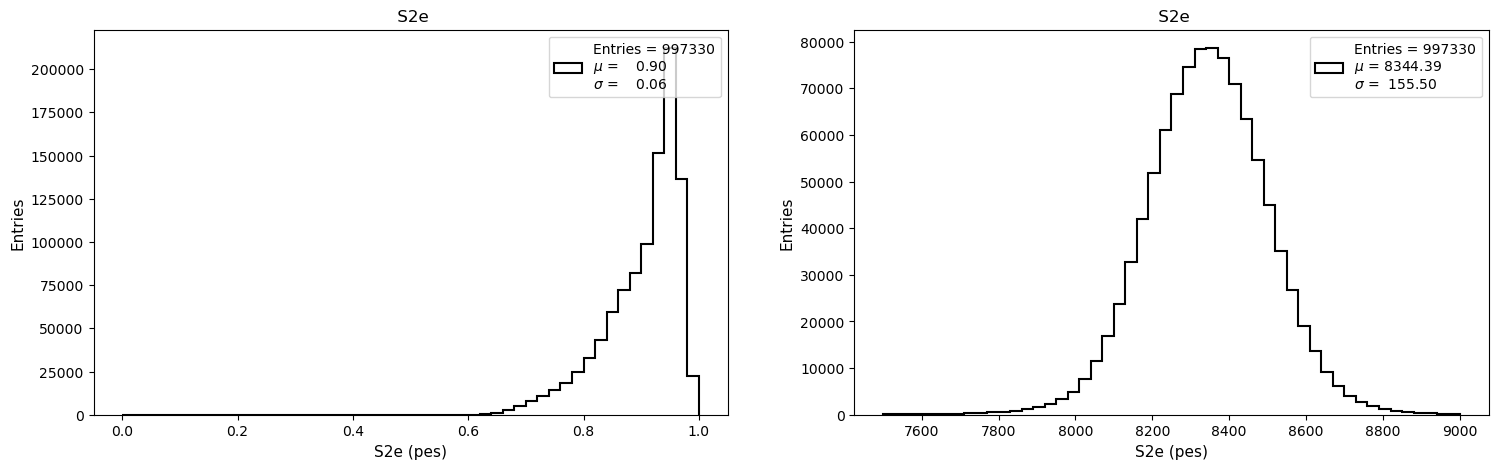

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
n, n, mu, std = hst.h1d(dfc.corrections, 50, [0,1], 
            ax = ax[0])
hst.plot_histo(hst.PlotLabels(x='S2e (pes)', y='Entries', title=" S2e"), ax[0], log=False)
           
n, n, mu, std = hst.h1d(dfc.Epes, 50, [7500,9000], 
            ax = ax[1])
hst.plot_histo(hst.PlotLabels(x='S2e (pes)', y='Entries', title=" S2e"), ax[1], log=False)
           
plt.show()

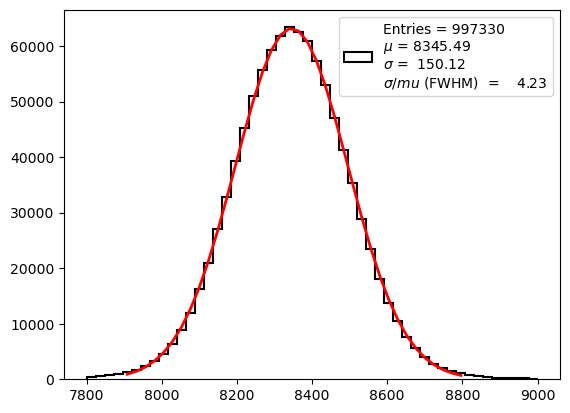

In [59]:
hp = ia.HistoPar(var = dfc.Epes, nbins = 50, range = [7800, 9000])
fp, fr = ia.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 3.0)
fc = ia.FitCollection(fp, hp, fr) 
ia.plot_fit_energy(fc)

In [60]:
ia.print_fit_energy(fc)

  Fit was valid = True
 Emu       = 8345.48639747422 +-0.15284404790681838 
 E sigma   = 150.11628109192668 +-0.1157152525318788 
 chi2    = 20.468248421390108 
 sigma E/E (FWHM)     (%) =4.227114439642431
 sigma E/E (FWHM) Qbb (%) =0.5459400995701112 


In [73]:
fc_list = ia.fit_Epes_vs_R(dfc)  # default 0–480 mm in 10 slices

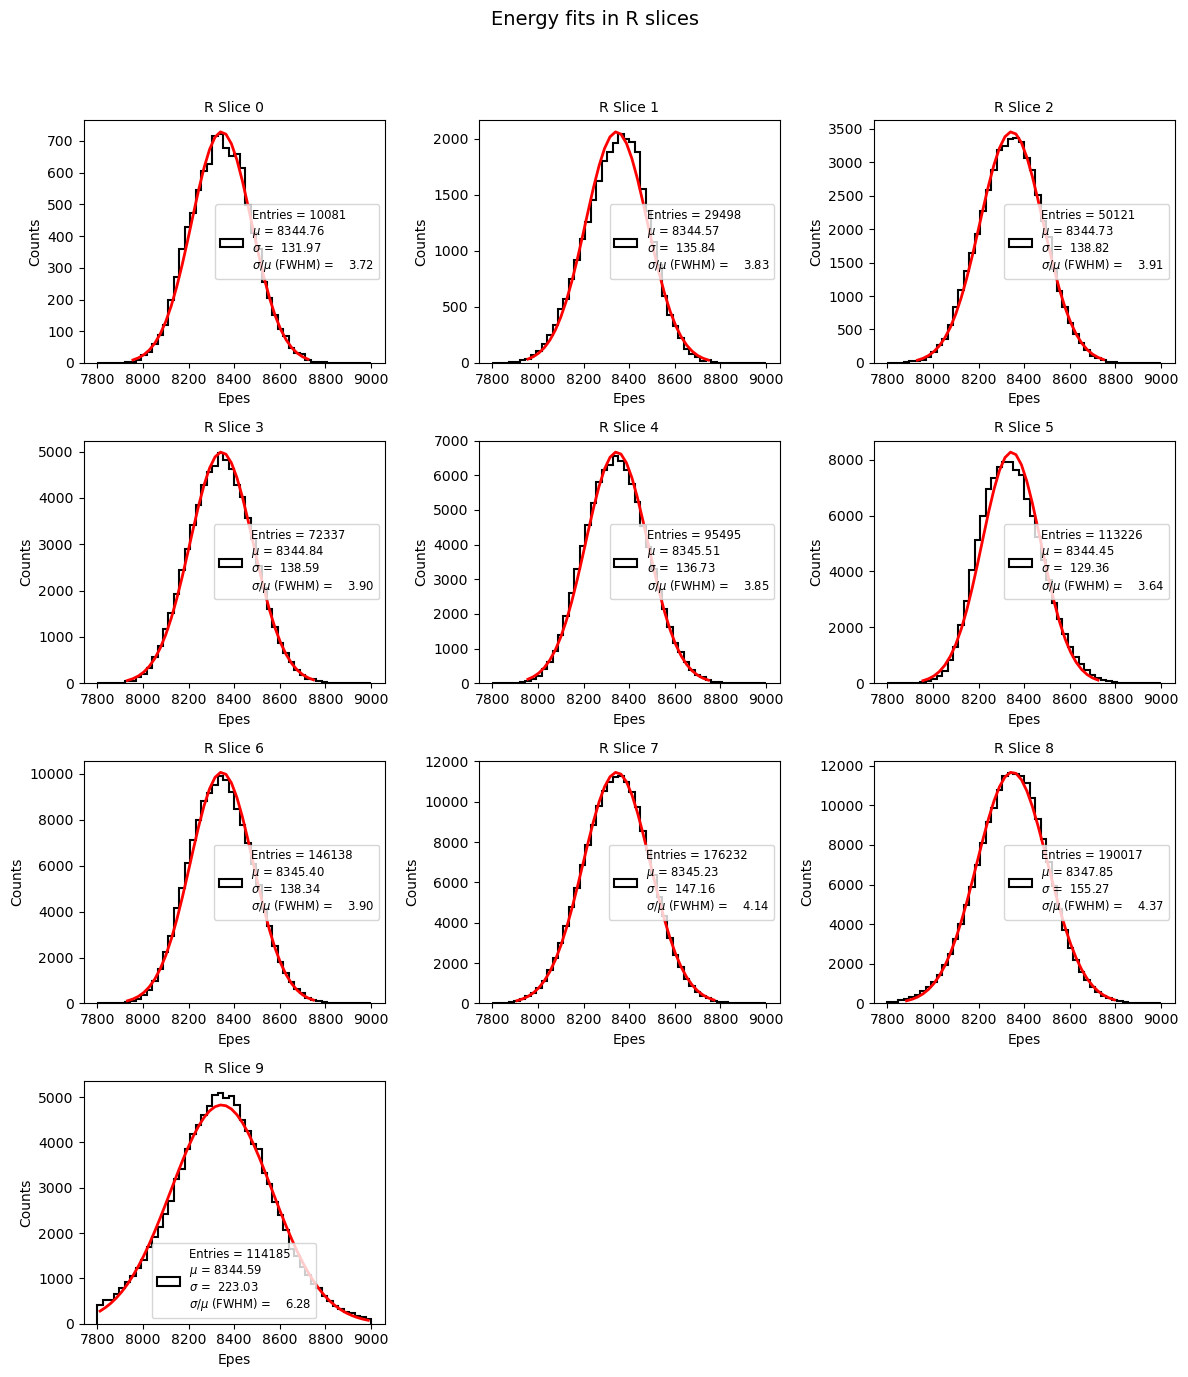

In [75]:
ia.plot_fit_energy_list(fc_list)

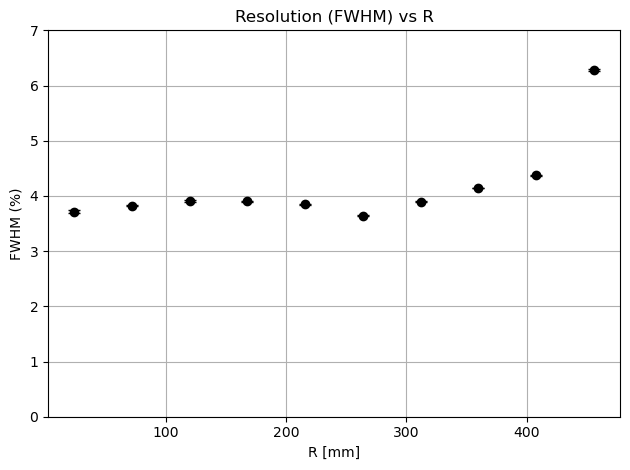

In [77]:
r_edges = np.linspace(0, 480, 11).tolist()
r_centers, fwhm_vals, fwhm_errs = ia.plot_resolution_vs_R(fc_list, r_edges)

In [98]:
r_edges=[275.0, 325.0, 375.0, 425.0, 450.0, 475.0]
fc_list2 = ia.fit_Epes_vs_R(dfc, r_edges=r_edges)  

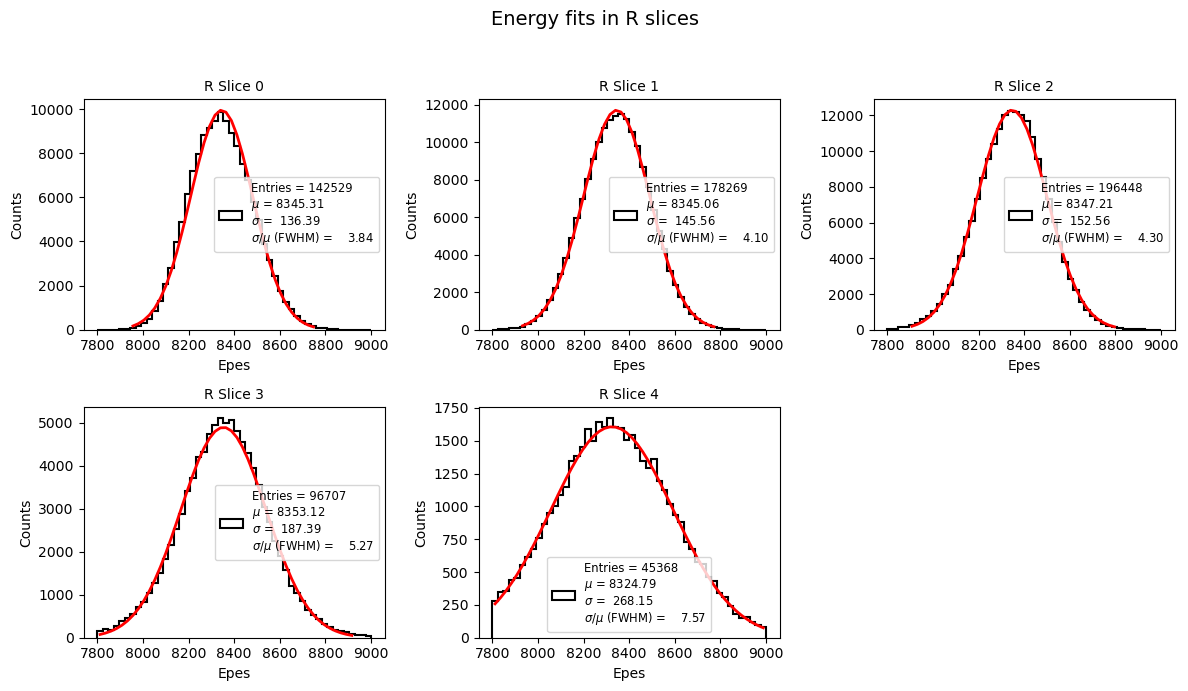

In [99]:
ia.plot_fit_energy_list(fc_list2)

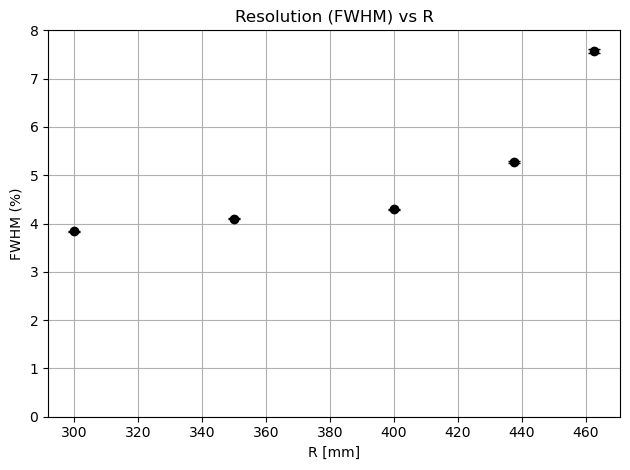

In [101]:
r_centers, fwhm_vals, fwhm_errs = ia.plot_resolution_vs_R(fc_list2, r_edges, ymax=8.0)

## Define chamber core as R < 400

In [102]:
dffc = dfc[dfc.R < 400]
ldffc = len(np.unique(dffc['event']))
print(f"NEvent fiducial core : {ldffc}")
print(f"eff:{(ldffc/ldf)*100:.2f}%")

NEvent fiducial core : 755471
eff:27.51%


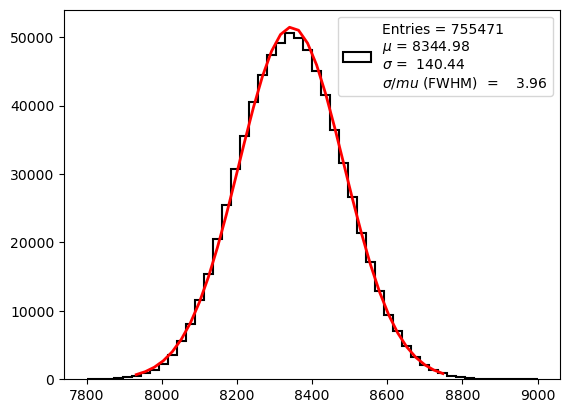

In [103]:
hp = ia.HistoPar(var = dffc.Epes, nbins = 50, range = [7800, 9000])
fp, fr = ia.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 3.0)
fc = ia.FitCollection(fp, hp, fr) 
ia.plot_fit_energy(fc)

In [104]:
r_edges = np.linspace(0, 400, 11).tolist()
fc_list3 = ia.fit_Epes_vs_R(dffc, r_edges=r_edges)  

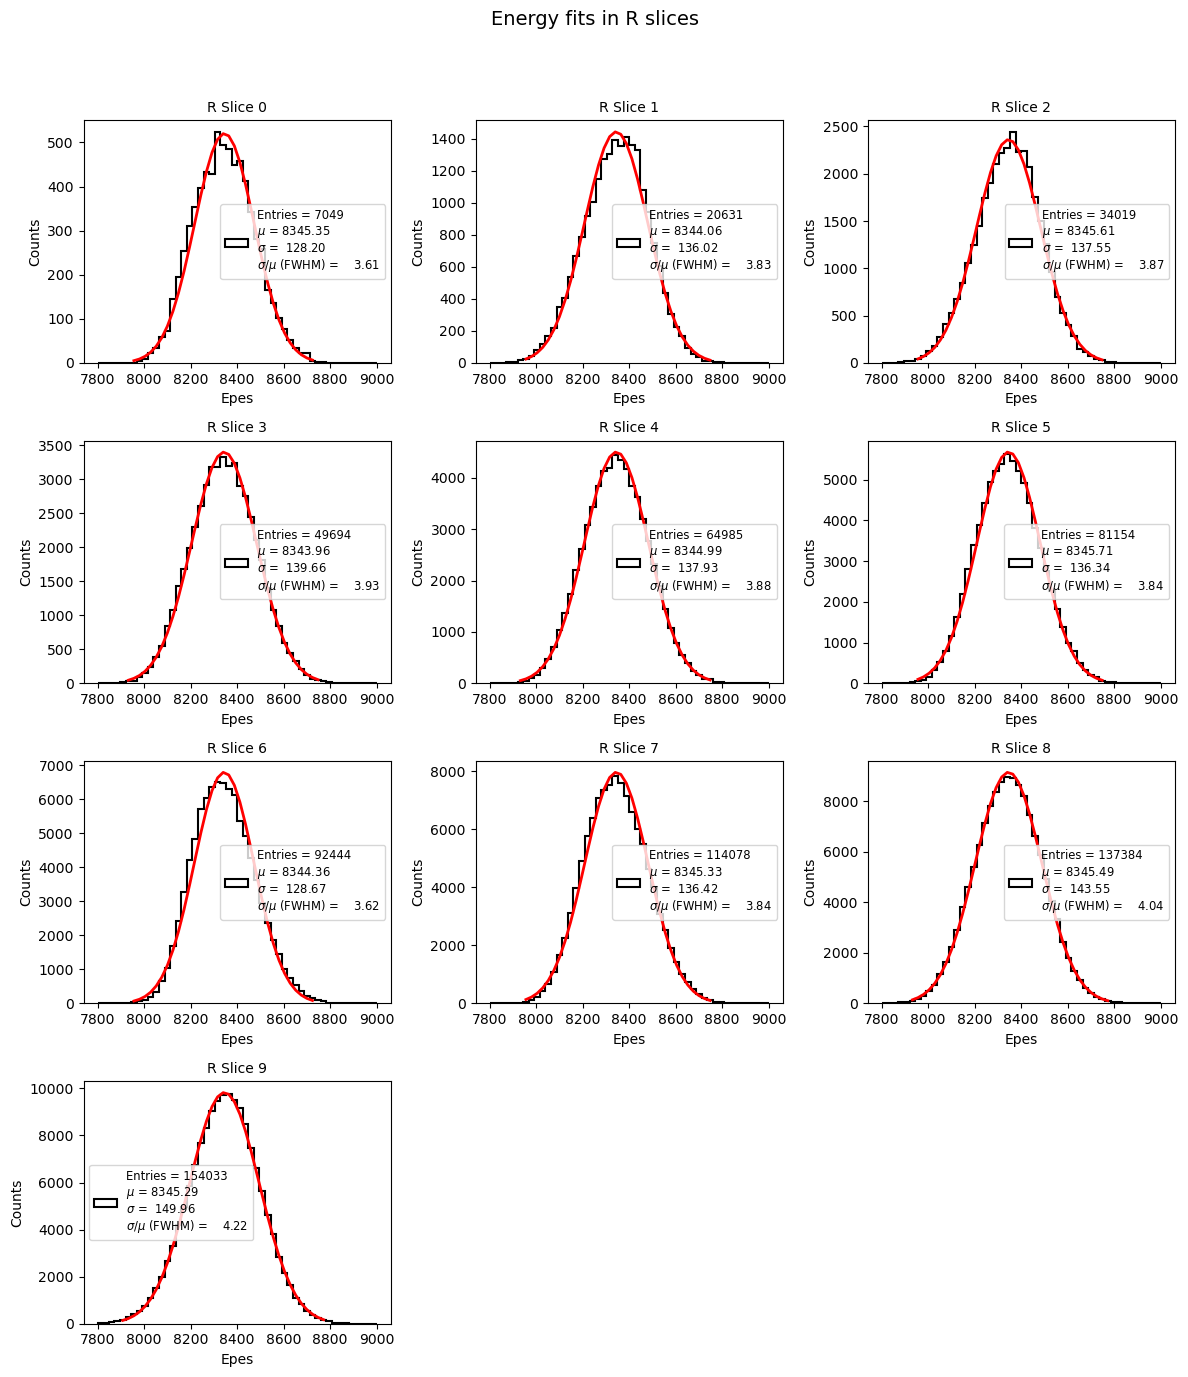

In [105]:
ia.plot_fit_energy_list(fc_list3)

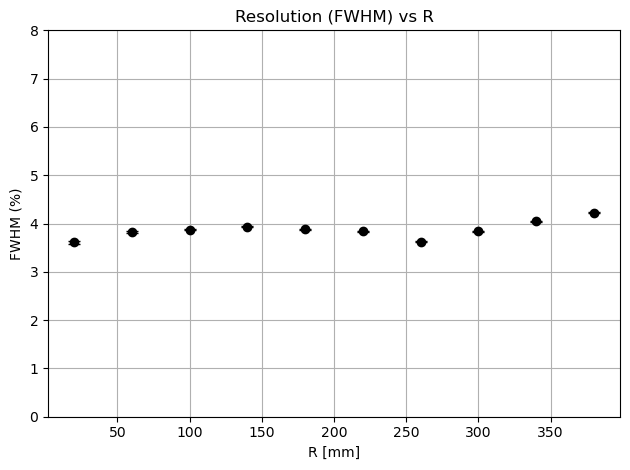

In [106]:
r_centers, fwhm_vals, fwhm_errs = ia.plot_resolution_vs_R(fc_list3, r_edges, ymax=8.0)